In [1]:
# We are using f_rest at 0.7, with a dynamic range that is 20% of that (sim.py).

# Goal: Test constrained NMF implementation on a version of the dataset that can actually be completely described by an NMF decomposition.
# - Implement a decay function to de-trend the data.

# Next steps:
# 1. Insert independent noise across pixels (this is noise from the sensor).
# 2. Laser noise is currently only multiplicative and shared across pixels: Change this
# 3. Hold shape of spectrum and relative order w.r.t peaks fixed.
# 4. Alternatively, hold shape of spectrum fixed and allow small scales / shifts.


# Done:
# 1. Learning H holding A fixed works
# 2. Traced and fixed bug that led to mismatch between A@H and Y (in ground truth data).
# 3. Fixed bug that introduced differences between A@H and Y (in synthetic data).
# 4. Revisited normalization at the time of initialization.
#     - h01 is fraction bound, so values are set accordingly.
#     - absorption and emission spectra are used to determine initial h_coef
#     - linear problem is solved effectively.

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import xarray as xr

from sourcesep.utils.config import load_config

xr.set_options(display_style="html", display_expand_data=False)
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", font_scale=0.8, rc=custom_params)
%config InlineBackend.figure_format='retina'

paths = load_config(dataset_key="all")

Paths are for dataset tagged: all


Paths are for dataset tagged: all
Paths are for dataset tagged: all


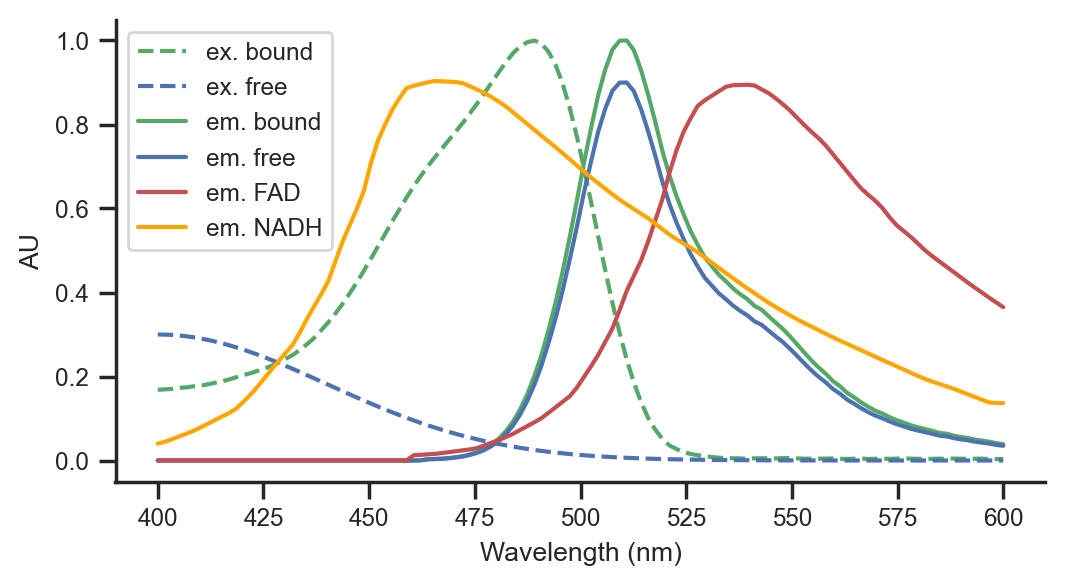

405       445       473       514       561
FAD   0.624710  0.867660  0.373060  0.000000  0.000000
NADH  0.017070  0.000000  0.000000  0.000000  0.000000
Wb    0.173241  0.397530  0.805277  0.140076  0.004060
Wf    0.297626  0.157636  0.058654  0.005064  0.000088

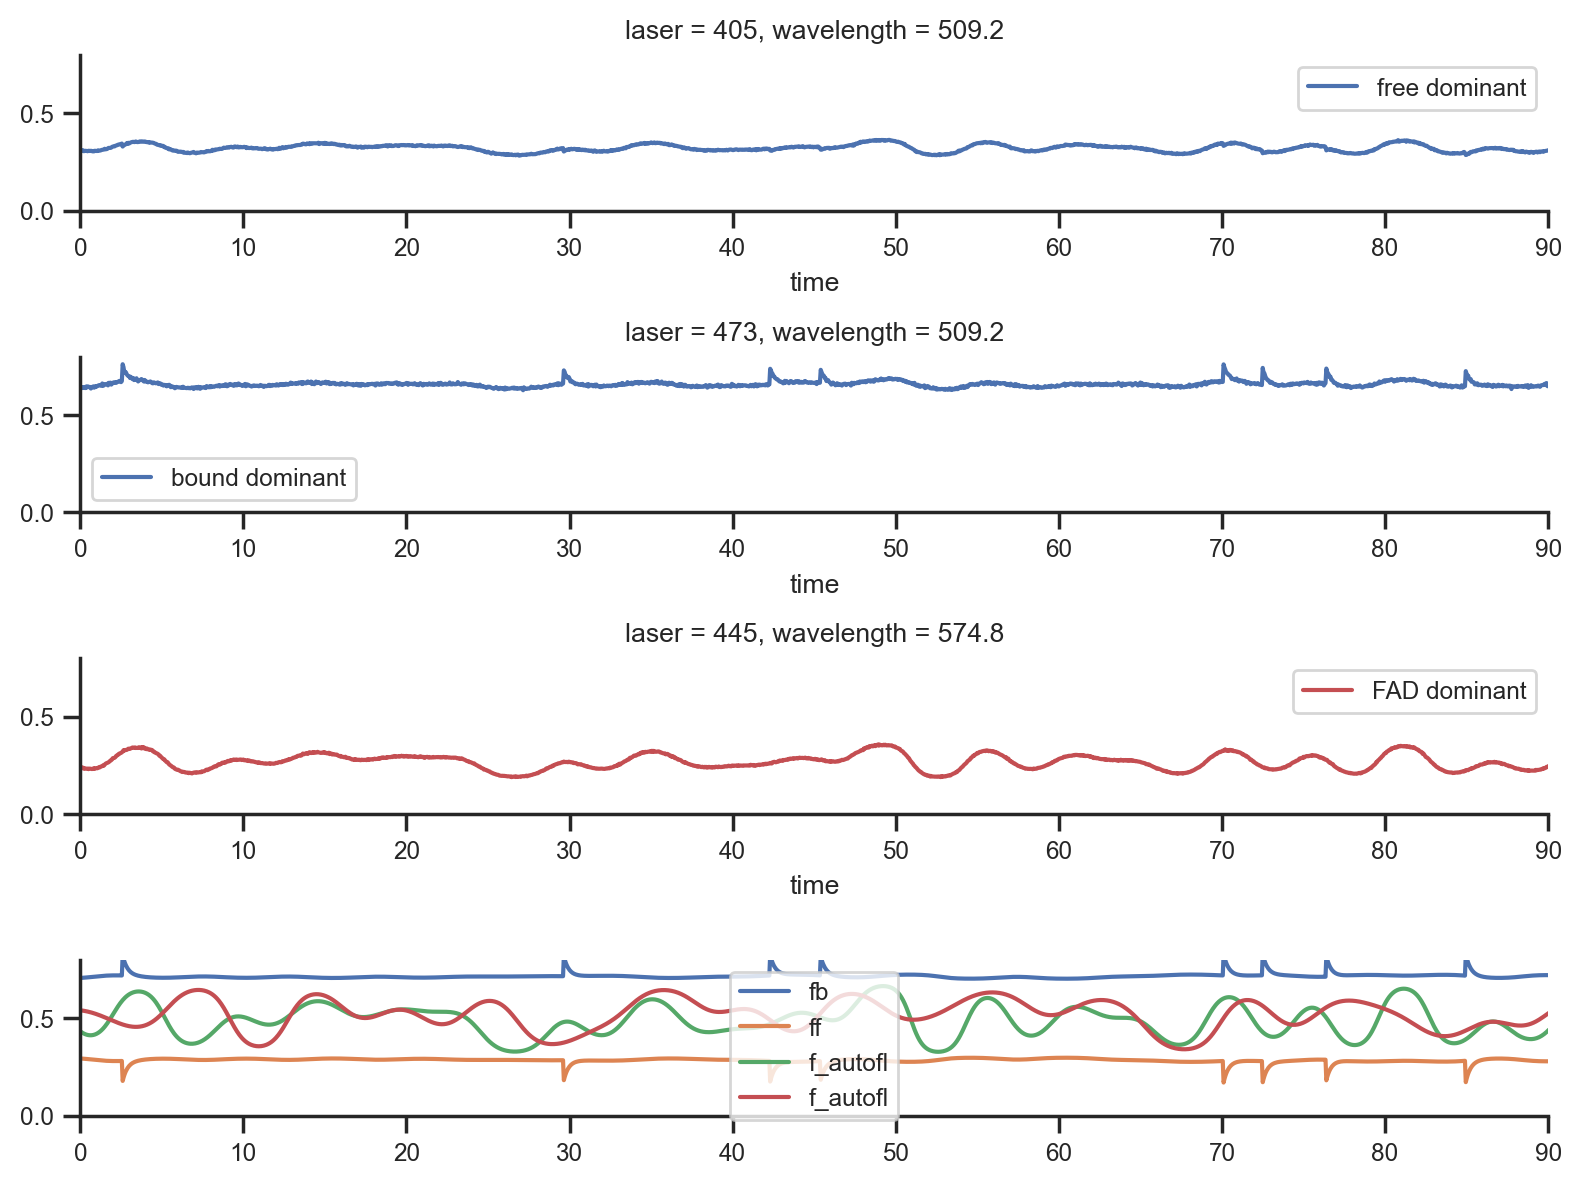

dict_keys(['O', 'OK', 'fb', 'ff', 'f_autofl', 'f_rest', 'f_dynamic_range', 'Wb', 'Wf', 'Wb_full', 'Wf_full', 'Sb', 
'Sf', 'S_autofl', 'P', 'H', 'fSWP', 'fSWP_autofl', 'fSWPH', 'fSWPH_autofl', 'f0SWPH', 'C_HbO', 'C_HbR', 'C_HbT', 
'f_HbO', 'Mu_HbO', 'Mu_HbR', 'notches', 'T_arr', 'L_arr'])

In [2]:
from sourcesep.models.datasets import test_data_v1

dat, sim, S, S_autofl, xdat, Y, W_df = test_data_v1()

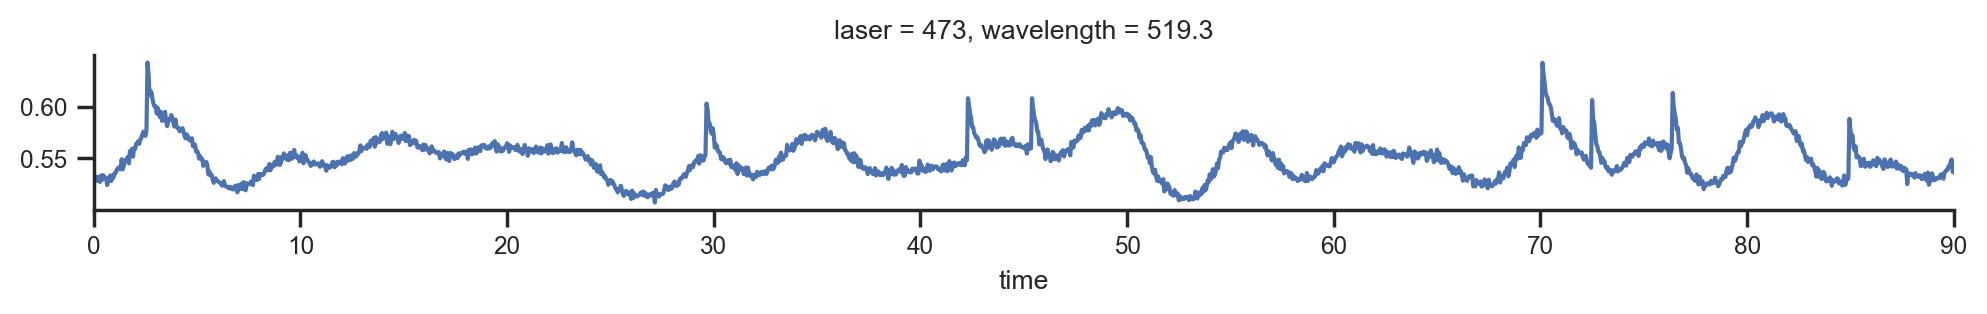

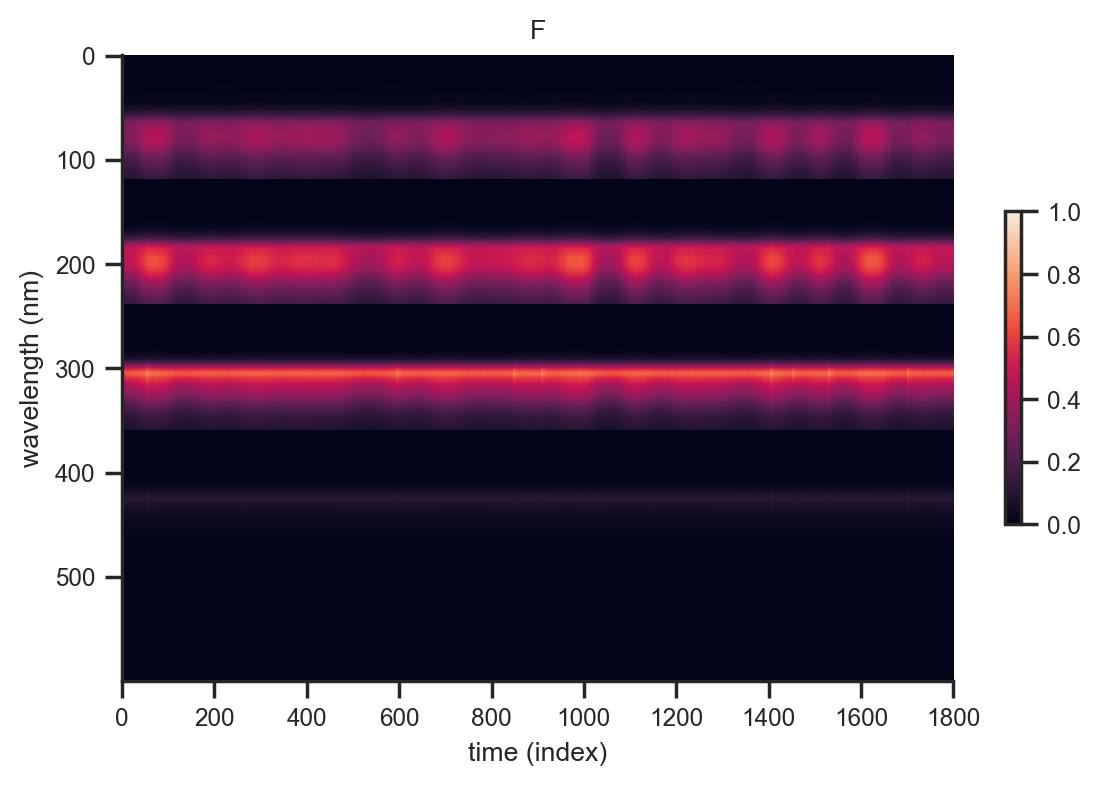

In [3]:
# Check normalized data across different channels
f, ax = plt.subplots(1, 1, figsize=(12, 1))
xdat.sel(wavelength=520, laser=473, method="nearest").plot()
ax.set(xlim=(0, 90))

f, ax = plt.subplots(1, 1, figsize=(6, 4))
f.colorbar(ax.imshow(Y, interpolation="nearest", aspect="auto", vmin=0, vmax=1), shrink=0.5)
ax.grid(visible=False)
ax.set(
    ylabel="wavelength (nm)",
    xlabel="time (index)",
    title="F",
    xlim=np.array((0, 90)) * sim.cfg["sensor"]["sampling_freq_Hz"],
)

plt.tight_layout()

In [4]:
# additive components for nmf for single indicator are from 3 sources: fb, ff, and autofl
# laser noise as was previously treated as a distinct source; this is quite different in data vs. simulation.
# laser noise is also very different in the frequency domain - we'll ignore this for now.

n_timepoints = xdat.shape[0]
n_channels = xdat.shape[1]
n_wavelengths = xdat.shape[2]
n_sources = 4

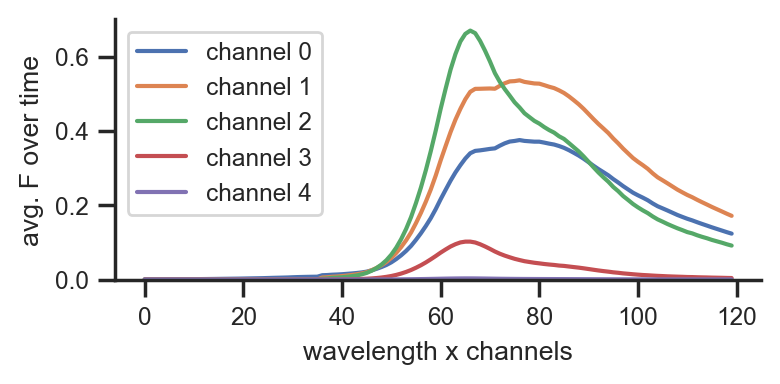

In [5]:
# this checks that data is correctly "unrolled" by keeping different wavelengths of each source together.
y_means = np.mean(Y, axis=1)
f, ax = plt.subplots(1, 1, figsize=(4, 2))
for i in range(n_channels):
    ax.plot(y_means[i * n_wavelengths : (i + 1) * n_wavelengths], label=f"channel {i}")
    ax.set(xlabel="wavelength x channels", ylabel="avg. F over time", ylim=(0, 0.7))
plt.legend()
plt.tight_layout()

In [6]:
display(W_df)

,405,445,473,514,561
FAD,0.624710,0.867660,0.373060,0.000000,0.000000
NADH,0.017070,0.000000,0.000000,0.000000,0.000000
Wb,0.173241,0.397530,0.805277,0.140076,0.004060
Wf,0.297626,0.157636,0.058654,0.005064,0.000088


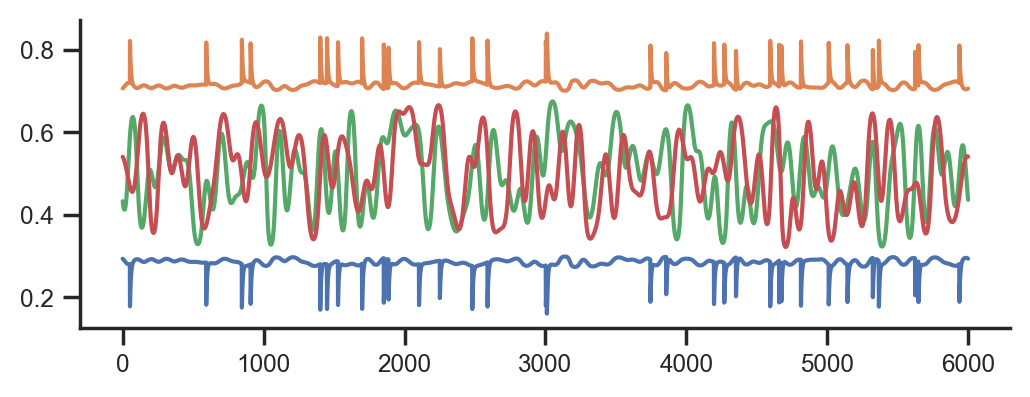

H shape:  (4, 6000)


In [7]:
# This is ground truth for the sources - NADH is ignored because excitation efficiency is very low across lasers.

f, ax = plt.subplots(1, 1, figsize=(6, 2))
ax.plot(dat["ff"], label="ff")
ax.plot(dat["fb"], label="fb")
ax.plot(dat["f_autofl"][:, 0], label="f_auto")
ax.plot(dat["f_autofl"][:, 1], label="f_auto_NADH")
plt.show()

H = np.concatenate([dat["fb"], dat["ff"], dat["f_autofl"][:, [0]], dat["f_autofl"][:, [1]]], axis=1)

H = H.T
print("H shape: ", (H.shape))

In [8]:
# We now need to initialize the A and H matrices
n_sources = 4
n_timepoints = Y.shape[1]
n_channels = 5
n_wavelengths = Y.shape[0] // n_channels

In [9]:
# populate ground truth
A = np.zeros((n_wavelengths * n_channels, n_sources))
X = np.zeros((n_sources, n_timepoints))

print("A: ", A.shape)
print("X: ", X.shape)
print("Y: ", Y.shape)

A:  (600, 4)
X:  (4, 6000)
Y:  (600, 6000)


In [10]:
source_names = ["Wb", "Wf", "FAD", "NADH"]
laser_names = W_df.columns
s = {}
s[0] = S["bound_em"].reshape(-1, 1)
s[1] = S["free_em"].reshape(-1, 1)
s[2] = S_autofl[0, :].reshape(-1, 1)
s[3] = S_autofl[1, :].reshape(-1, 1)

# efficiency of emission from different sources per channel
s_ch = {}
for i, src in enumerate(source_names):
    s_ch[i] = W_df.loc[src, laser_names].values

a_col = {}
for src in range(n_sources):
    a_col[src] = np.concatenate([s_ch[src][ch] * s[src] for ch in range(n_channels)])
    a_col[src] = a_col[src].reshape(-1, 1)

A = np.concatenate([a_col[i] for i in range(n_sources)], axis=1)

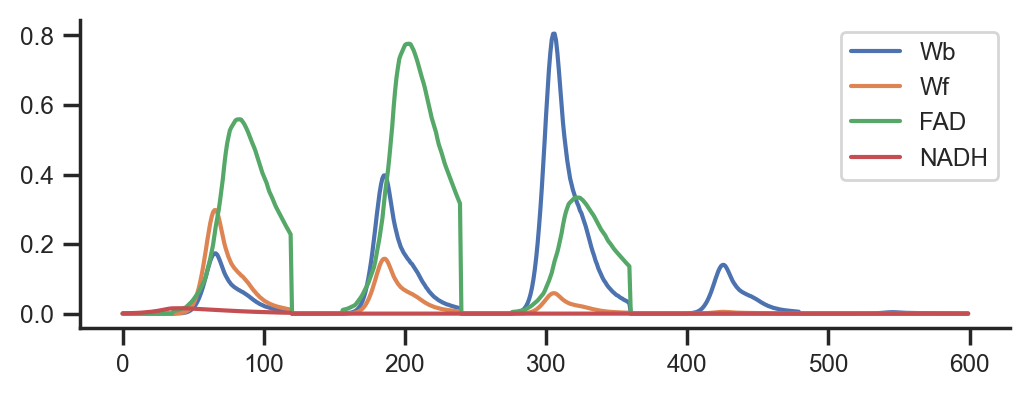

,405,445,473,514,561
Wb,0.173241,0.397530,0.805277,0.140076,0.004060
Wf,0.297626,0.157636,0.058654,0.005064,0.000088
FAD,0.624710,0.867660,0.373060,0.000000,0.000000
NADH,0.017070,0.000000,0.000000,0.000000,0.000000


In [11]:
f, ax = plt.subplots(1, 1, figsize=(6, 2))
for i in range(n_sources):
    ax.plot(a_col[i], label=source_names[i])
plt.legend()
plt.show()

display(W_df.loc[source_names, :])

In [12]:
# Checks to traceback a discrepancy between A @ H and Y.
# We expect this to be roughly equal to Y for no-hemodynamics case.

# WW = W_df.loc[source_names, :].values
# WW.shape

# SS = np.concatenate((
#     S["bound_em"].reshape(1, -1),
#     S["free_em"].reshape(1, -1),
#     S_autofl[0, :].reshape(1, -1),
#     S_autofl[1, :].reshape(1, -1)),
#     axis=0,
# )
# HH = H.T.copy()

# print(WW.shape)
# print(SS.shape)
# print(HH.shape)

# for i in range(4):
#     print(np.allclose(s[i].reshape(-1, 1), SS[i,:].reshape(-1, 1)))
#     temp = s[i].flatten()/(SS[i,:].flatten()+1e-7)

# f, ax = plt.subplots(1, 1, figsize=(2, 2))
# for i in range(4):
#     ax.scatter(s[i].flatten(), SS[i,:].flatten(), s=1)
# ax.plot([0, 1], [0, 1], color="k", alpha=0.1)
# plt.show()

## aa should be close to A
# f, ax = plt.subplots(1, 1, figsize=(6, 2))
# ax.plot(A)
# plt.show()

# aa = []
# for i in range(4):
#     print(WW[i,0])
#     temp = np.concatenate([WW[i, j] * SS[i, :].reshape(-1, 1) for j in range(5)])
#     aa.append(temp)
# aa = np.concatenate(aa, axis=1)
# f, ax = plt.subplots(1, 1, figsize=(6, 2))
# ax.plot(aa)
# plt.show()

# np.allclose(aa,A)

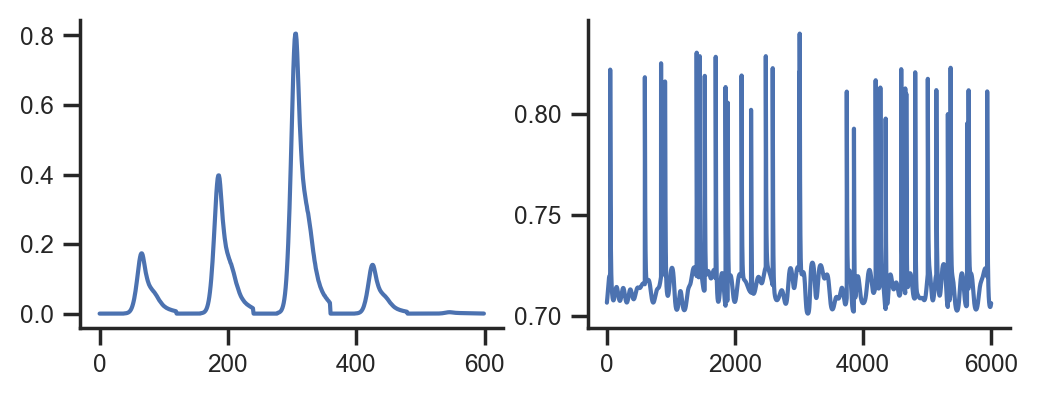

In [13]:
f, ax = plt.subplots(1, 2, figsize=(6, 2))
ax[0].plot(A[:, 0])
ax[1].plot(H[0, :])
plt.show()

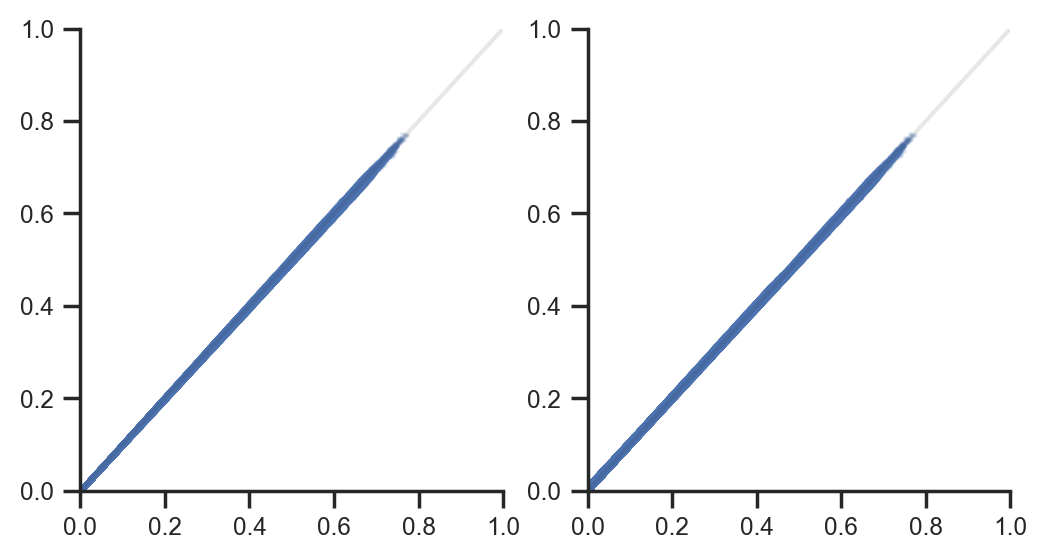

In [14]:
# the jitter around 1-1 comes from laser power
# the losses due to ignoring the extra autofluoresence component are negligible

c1 = A @ H
c2 = A[:, [0, 1, 2]] @ H[[0, 1, 2], :]

f, ax = plt.subplots(1, 2, figsize=(6, 3))
ax[0].scatter(c1.flatten(), Y.flatten(), alpha=0.1, s=1)
ax[1].scatter(c2.flatten(), Y.flatten(), alpha=0.1, s=1)

for axx in ax:
    axx.plot([0, 1], [0, 1], color="k", alpha=0.1)
    axx.set(xlim=(0, 1), ylim=(0, 1))
plt.show()

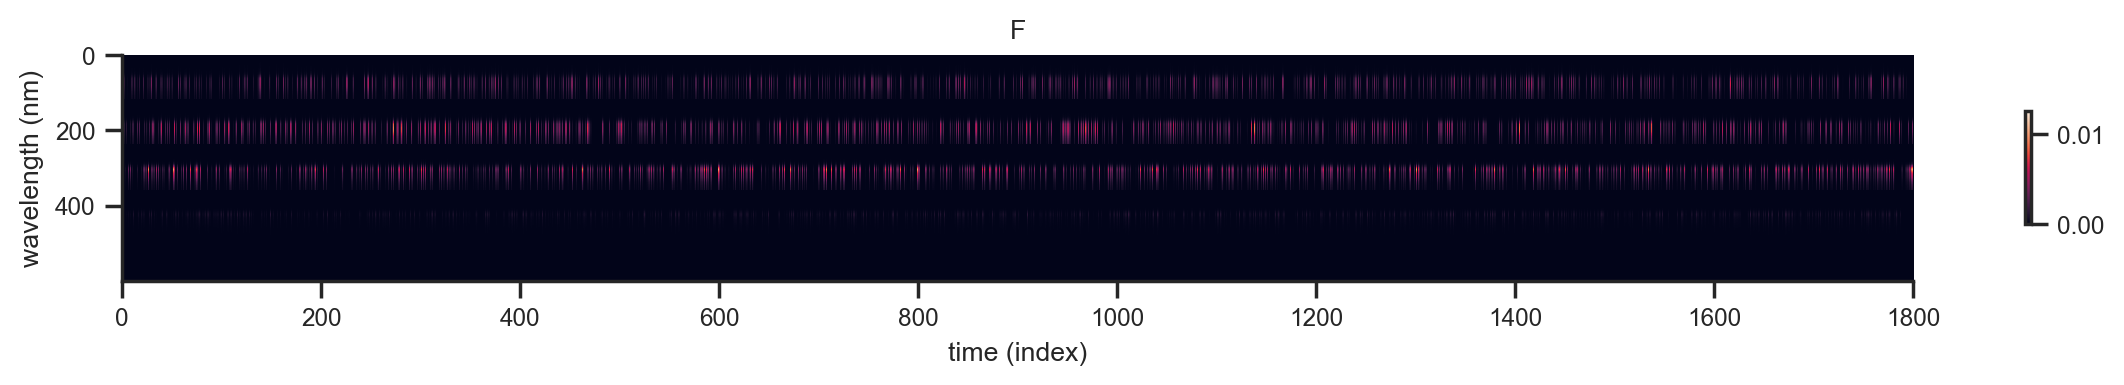

In [15]:
# checking if there are structured discrepancies (there shouldn't be in the no-hemodynamics case)

f, ax = plt.subplots(1, 1, figsize=(12, 2))
f.colorbar(ax.imshow(Y - A @ H, interpolation="nearest", aspect="auto", vmin=0), shrink=0.5)
ax.grid(visible=False)
ax.set(
    title="F",
    ylabel="wavelength (nm)",
    xlabel="time (index)",
    xlim=np.array((0, 90)) * sim.cfg["sensor"]["sampling_freq_Hz"],
)

plt.tight_layout()

In [16]:
A = A[:, [0, 1, 2]]
H = H[[0, 1, 2], :]
n_sources = 3

In [17]:
# Now we fix initialization + normalization of H

import torch

device = "cpu"


def parameter(x):
    return torch.tensor(x, requires_grad=True, dtype=torch.float32)


a_coef = {}
a_coef[0] = parameter([0.173241, 0.397530, 0.805277, 0.140076, 0.004060])
a_coef[1] = parameter([0.297626, 0.157636, 0.058654, 0.005064, 0.000088])
a_coef[2] = parameter([0.624710, 0.867660, 0.373060, 0.000000, 0.000000])


# fmt: off
a = {}
a[0] = parameter(1.0 * s[0].reshape(n_wavelengths, 1) + 0.0 * np.random.rand(n_wavelengths, 1))
a[1] = parameter(1.0 * s[1].reshape(n_wavelengths, 1) + 0.0 * np.random.rand(n_wavelengths, 1))
a[2] = parameter(1.0 * s[2].reshape(n_wavelengths, 1) + 0.0 * np.random.rand(n_wavelengths, 1))
# fmt: on

with torch.no_grad():
    a_ = {}
    for src in range(n_sources):
        a_[src] = torch.cat(list(a_coef[src][ch] * a[src] for ch in range(n_channels)), dim=0)
    A_ = torch.cat((a_[0], a_[1], a_[2]), dim=1)

AA = A_.detach().numpy().copy()
Y_init = AA @ np.ones((AA.shape[1], Y.shape[1]))
fac = np.median(Y_init[Y > 0] / Y[Y > 0])

In [18]:
from scipy.optimize import nnls
from tqdm import tqdm


H_init = np.zeros((AA.shape[1], Y.shape[1]))
for i in tqdm(range(Y.shape[1])):
    h, rnorm = nnls(AA, Y[:, i])
    H_init[:, i] = h

100%|██████████| 6000/6000 [00:00<00:00, 16338.71it/s]


(3, 6000)
(4, 6000)


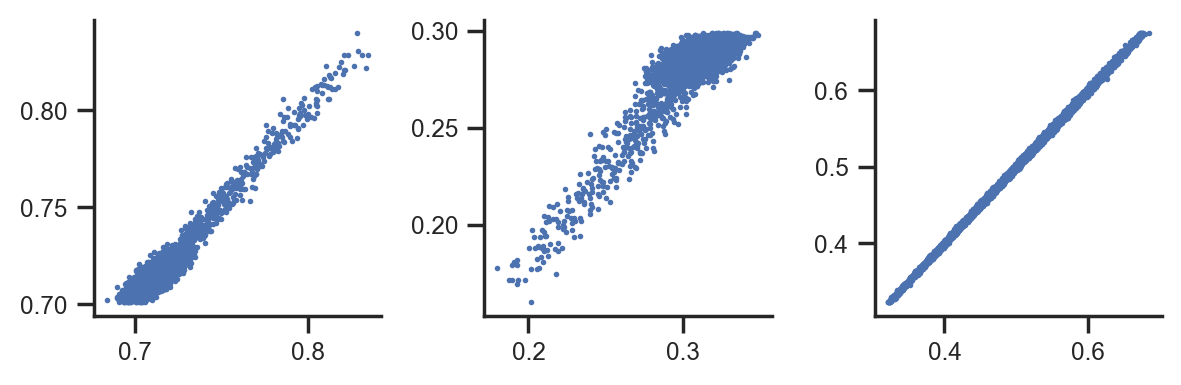

In [19]:
print(H.shape)
print(X.shape)

# scatter plot X rows vs Y rows. Use 3 subplots, one for each row.
f, ax = plt.subplots(1, 3, figsize=(6, 2))
for i in range(3):
    ax[i].scatter(H_init[i, :], H[i, :], s=1)
plt.tight_layout()
plt.show()

In [20]:
sigma_h = 0.03
mu_h = 0.3
# h_coef = parameter([1/(fac*mu_h), 1/(fac*mu_h)])
# h01 = parameter(sigma_h * np.random.randn(1, n_timepoints) + mu_h)  # req. positive entries
# h2 = parameter(sigma_h * np.random.randn(1, n_timepoints) + mu_h)  # req. positive entries

h_coef = parameter([1, 1])
h01 = parameter(H_init[[0], :])
h2 = parameter(H_init[[2], :])

# with torch.no_grad():
# we want entries of h01 to be small compared to 1.
# (since we rely on 1-h01 to calculate h1)
# c = 0.5
# h01_norm = c * (h01.shape[1]) ** 0.5 / torch.norm(h01, p=2)
# h01.data = h01 * h01_norm
# h_coef.data = h_coef / h01_norm

for p in [a_coef[0], a_coef[1], a_coef[2], a[0], a[1], a[2]] + [h_coef, h01, h2]:
    p.to(device)

# observation
X = torch.as_tensor(Y.copy(), dtype=torch.float32, device=device)

In [21]:
h_coef

tensor([1., 1.], requires_grad=True)

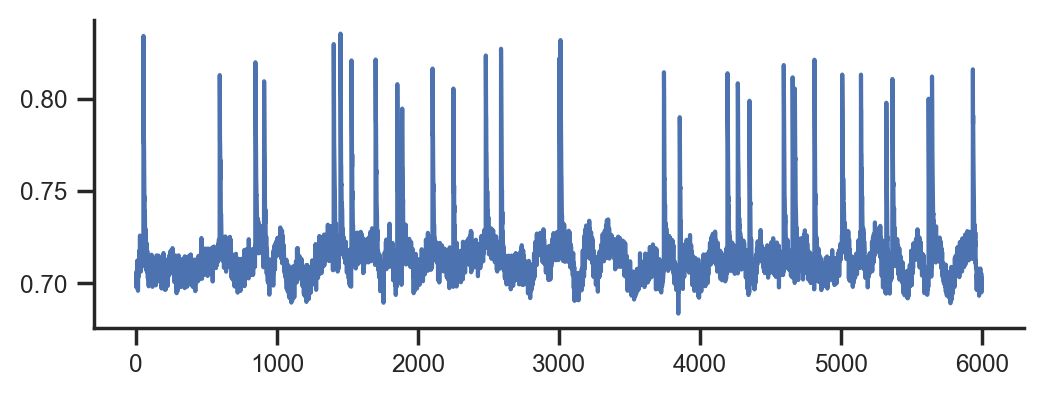

In [22]:
f, ax = plt.subplots(1, 1, figsize=(6, 2))
ax.plot(h01.detach().numpy().T[:, 0])

In [23]:
# learning rate
lr = 1e-4
n_steps = 4_000

# post gradient step modifiers:
min_value = 1e-8
prox_plus = torch.nn.Threshold(0, min_value)


def prox_norm(x):
    return (x / torch.norm(x, p=2)) * torch.sqrt(torch.tensor(float(a[0].numel()), dtype=torch.float32))

tensor(0.0010, grad_fn=<MeanBackward0>)
tensor(0.1123, grad_fn=<MeanBackward0>)
tensor(0.1132)
tensor([1., 1.], requires_grad=True)


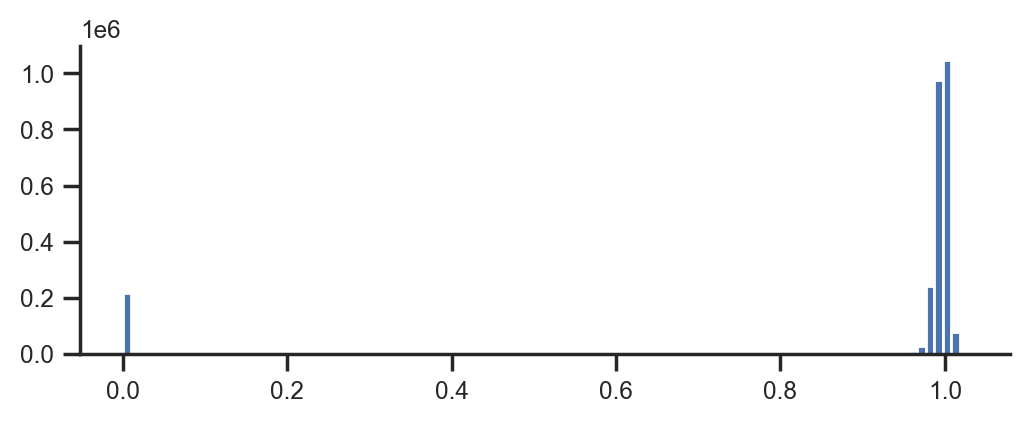

[(0.0, 1.0)]

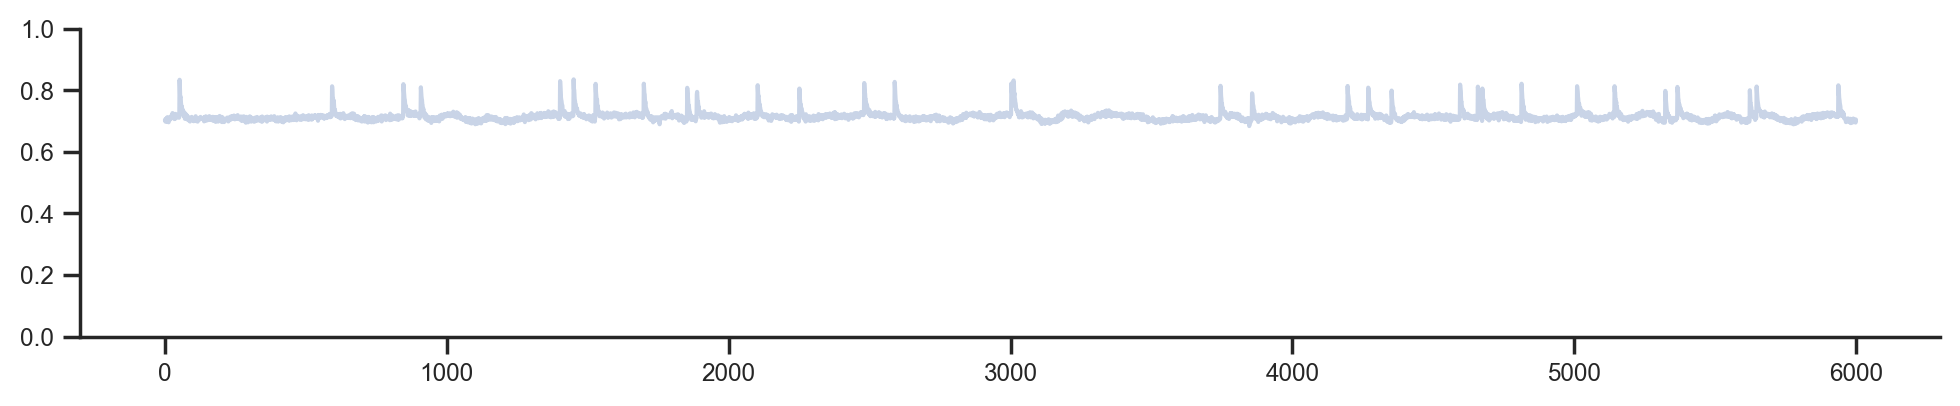

In [24]:
h0_ = h_coef[0] * h01
h1_ = prox_plus(h_coef[1] * (1 - h01))
H_ = torch.cat((h0_, h1_, h2), dim=0)

X_ = torch.matmul(A_, H_)

print(torch.mean(torch.abs((X_ - X))))
print(torch.mean(torch.abs((X_))))
print(torch.mean(torch.abs((X))))
print(h_coef)

YY = X_.detach().numpy()
XX = X.detach().numpy()
YY = YY[XX > 0] / XX[XX > 0]

f, ax = plt.subplots(1, 1, figsize=(6, 2))
ax.hist(YY, bins=100)
plt.show()

f, ax = plt.subplots(1, 1, figsize=(12, 2))
ax.plot(h01.detach().numpy().T, alpha=0.3)
ax.set(ylim=(0, 1))

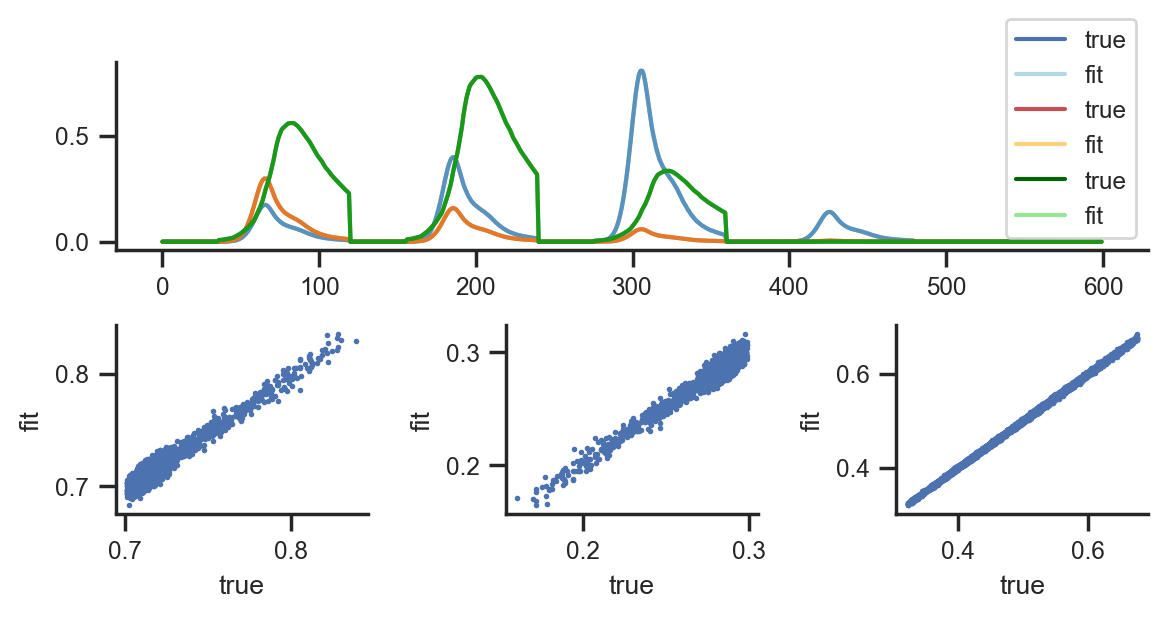

Step: 0, Loss: 16.68787384033203
Step: 0, h_coef: tensor([1.0001, 1.0000], requires_grad=True)
Step: 0, a_coef[0]: tensor([0.1732, 0.3975, 0.8053, 0.1401, 0.0041], requires_grad=True)
Step: 0, a_coef[1]: tensor([2.9763e-01, 1.5764e-01, 5.8654e-02, 5.0640e-03, 8.8000e-05],
       requires_grad=True)
Step: 0, a_coef[2]: tensor([0.6247, 0.8677, 0.3731, 0.0000, 0.0000], requires_grad=True)


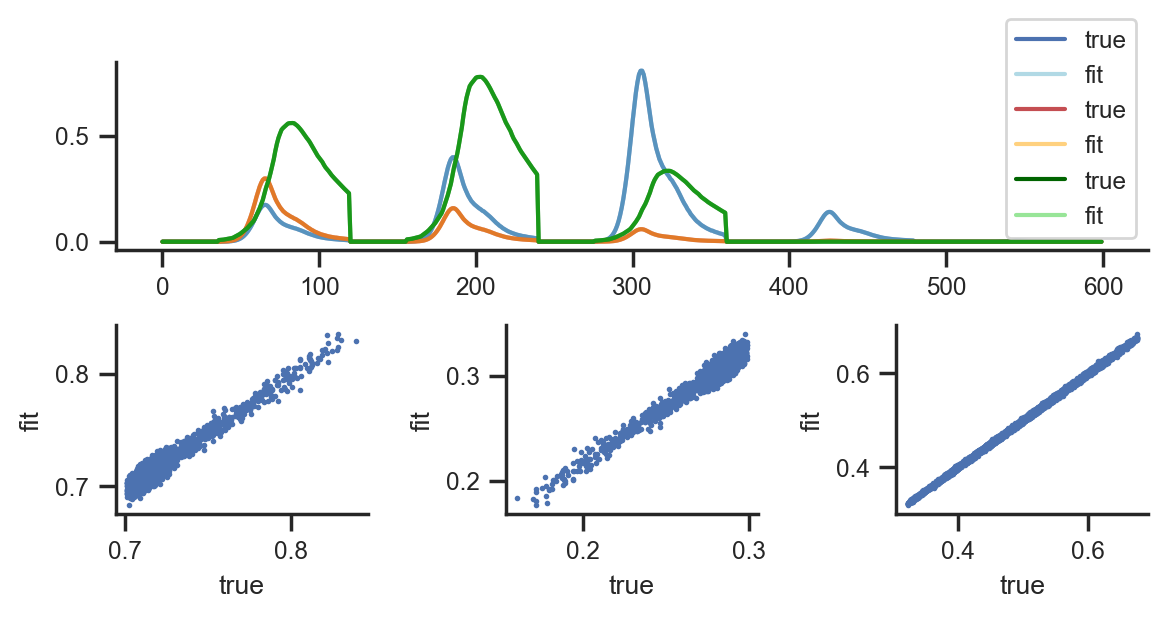

Step: 2000, Loss: 11.85609245300293
Step: 2000, h_coef: tensor([1.0001, 1.0732], requires_grad=True)
Step: 2000, a_coef[0]: tensor([0.1732, 0.3975, 0.8053, 0.1401, 0.0041], requires_grad=True)
Step: 2000, a_coef[1]: tensor([2.9763e-01, 1.5764e-01, 5.8654e-02, 5.0640e-03, 8.8000e-05],
       requires_grad=True)
Step: 2000, a_coef[2]: tensor([0.6247, 0.8677, 0.3731, 0.0000, 0.0000], requires_grad=True)


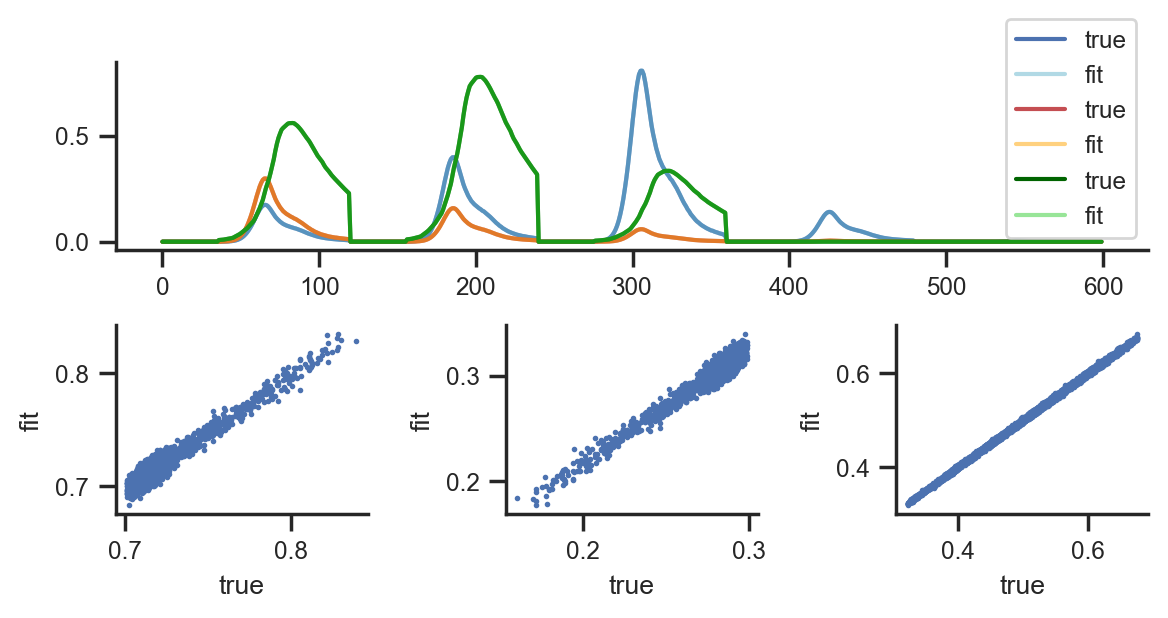

Step: 4000, Loss: 11.852930068969727
Step: 4000, h_coef: tensor([1.0001, 1.0734], requires_grad=True)
Step: 4000, a_coef[0]: tensor([0.1732, 0.3975, 0.8053, 0.1401, 0.0041], requires_grad=True)
Step: 4000, a_coef[1]: tensor([2.9763e-01, 1.5764e-01, 5.8654e-02, 5.0640e-03, 8.8000e-05],
       requires_grad=True)
Step: 4000, a_coef[2]: tensor([0.6247, 0.8677, 0.3731, 0.0000, 0.0000], requires_grad=True)


In [27]:
lambda_tv_A = 1e-5
lambda_tv_H = 1e-5

loss_list = []
tv_norm_loss_A_list = []
tv_norm_loss_H_list = []
reconstruction_loss_list = []
for i in range(n_steps + 1):
    a_ = {}
    for src in range(n_sources):
        a_[src] = torch.cat(list(a_coef[src][ch] * a[src] for ch in range(n_channels)), dim=0)
    A_ = torch.cat((a_[0], a_[1], a_[2]), dim=1)

    h0_ = h_coef[0] * h01
    h1_ = prox_plus(h_coef[1] * (1 - h01))
    H_ = torch.cat((h0_, h1_, h2), dim=0)

    X_ = torch.matmul(A_, H_)
    reconstruction_loss = torch.linalg.matrix_norm(X_ - X, ord="fro") ** 2
    tv_norm_loss_A = torch.sum(
        torch.as_tensor([(torch.abs(a[src][1:] - a[src][:-1])).sum() for src in range(n_sources)])
    )
    tv_norm_loss_H = torch.abs(h01[:, 1:] - h01[:, :-1]).sum() + torch.abs(h2[:, 1:] - h2[:, :-1]).sum()
    reconstruction_loss_list.append(reconstruction_loss.item())
    tv_norm_loss_A_list.append(tv_norm_loss_A.item())
    tv_norm_loss_H_list.append(tv_norm_loss_H.item())

    loss = reconstruction_loss + lambda_tv_A * tv_norm_loss_A + lambda_tv_H * tv_norm_loss_H

    loss.backward()
    loss_list.append(loss.item())

    with torch.no_grad():
        # step and project
        if i < 1e8:
            param_list = [h01, h2, h_coef]
        else:
            # fmt: off
            param_list = [
                a[0], a[1], a[2],
                a_coef[0], a_coef[1], a_coef[2],
                h01, h2, h_coef,
            ]
            # fmt: on

        # in-place operation to clip gradients by norm
        torch.nn.utils.clip_grad_norm_(param_list, 1.0)

        for p in param_list:
            # gradient is also clipped by value to [-1,1]
            p -= lr * torch.clamp(p.grad, -1, 1)
            p.grad.zero_()
            p.data = prox_plus(p)

        # scale for spectral shape from each source
        # for p in [a[0], a[1], a[2]]:
        #   p.data = prox_norm(p)

        # sum of contribution across channels is 1
        # for p in (a_coef[0], a_coef[1], a_coef[2]):
        #    p.data = p/torch.sum(p)

        # If saturation, then rescale time series (and coefficient) by a constant.
        sloop = 0
        while torch.sum(h01 > 1) > (0.05 * h01.numel()):
            # print only the first time
            if sloop == 0:
                print("h01 saturated")
            rescale_C = 0.90
            h01.data = h01 * rescale_C
            h_coef.data = h_coef / rescale_C
            sloop += 1

        # keep the norm of h01 to be 1, and scale h_coef accordingly
        # h2 does not need to be normalized this way
        # c = 0.5
        # h01_norm = c * (h01.shape[1])**0.5 / torch.norm(h01, p=2)
        # h01.data = (h01 * h01_norm)
        # h_coef.data = h_coef / h01_norm

    if i % 2000 == 0:
        # Create a grid of 2 rows and 3 columns
        gs = gridspec.GridSpec(2, 3, figure=plt.figure(figsize=(6, 3)))

        # This plot spans all columns of the first row
        ax1 = plt.subplot(gs[0, :])
        ax1.plot(A[:, 0], c="b", label="true")
        ax1.plot(A_[:, 0].detach().numpy(), alpha=0.5, c="c", label="fit")
        ax1.plot(A[:, 1], c="r", label="true")
        ax1.plot(A_[:, 1].detach().numpy(), c="orange", alpha=0.5, label="fit")
        ax1.plot(A[:, 2], c="darkgreen", label="true")
        ax1.plot(A_[:, 2].detach().numpy(), c="limegreen", alpha=0.5, label="fit")
        ax1.legend()

        ax2 = plt.subplot(gs[1, 0])  # first column of the second row
        ax2.scatter(H[0, :], H_[0, :].detach().numpy(), s=1, label="true")
        ax2.set(xlabel="true", ylabel="fit")

        ax3 = plt.subplot(gs[1, 1])  # second column of the second row
        ax3.scatter(H[1, :], H_[1, :].detach().numpy(), s=1, label="true")
        ax3.set(xlabel="true", ylabel="fit")

        ax4 = plt.subplot(gs[1, 2])  # third column of the second row
        ax4.scatter(H[2, :], H_[2, :].detach().numpy(), s=1, label="true")
        ax4.set(xlabel="true", ylabel="fit")

        plt.tight_layout()
        plt.show()

        # f, ax = plt.subplots(3, 1, figsize=(6,3))
        # ax[0].plot(np.ravel(h01.detach().numpy()),c='b')
        # ax[1].plot(np.ravel(1-h01.detach().numpy()), c='r')
        # ax[2].plot(np.ravel(h2.detach().numpy()), c='g')
        # for ax in ax:
        #     ax.set(ylim=(0,1.5))
        # plt.tight_layout()
        # plt.show()

        print(f"Step: {i}, Loss: {loss.item()}")
        print(f"Step: {i}, h_coef: {h_coef}")
        print(f"Step: {i}, a_coef[0]: {a_coef[0]}")
        print(f"Step: {i}, a_coef[1]: {a_coef[1]}")
        print(f"Step: {i}, a_coef[2]: {a_coef[2]}")

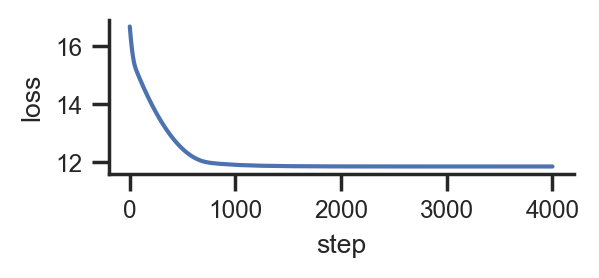

In [28]:
f, ax = plt.subplots(1, 1, figsize=(3, 1))
ax.plot(loss_list)
ax.set(ylabel="loss", xlabel="step")
plt.show()

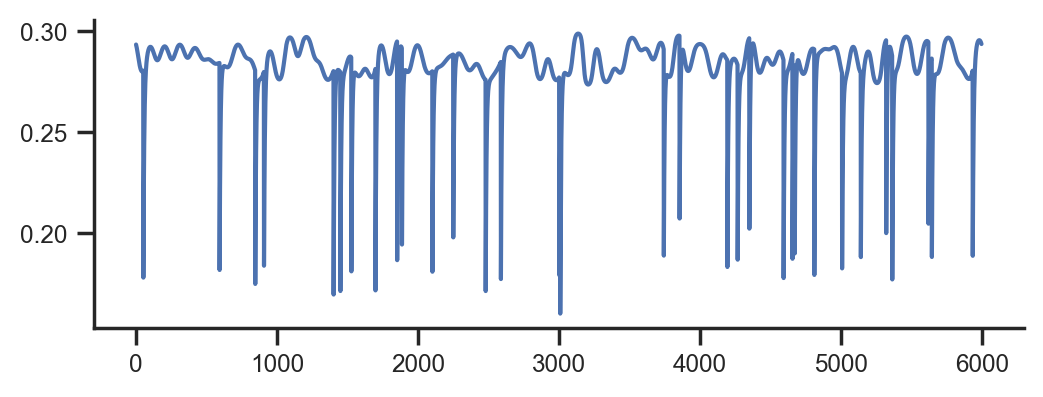

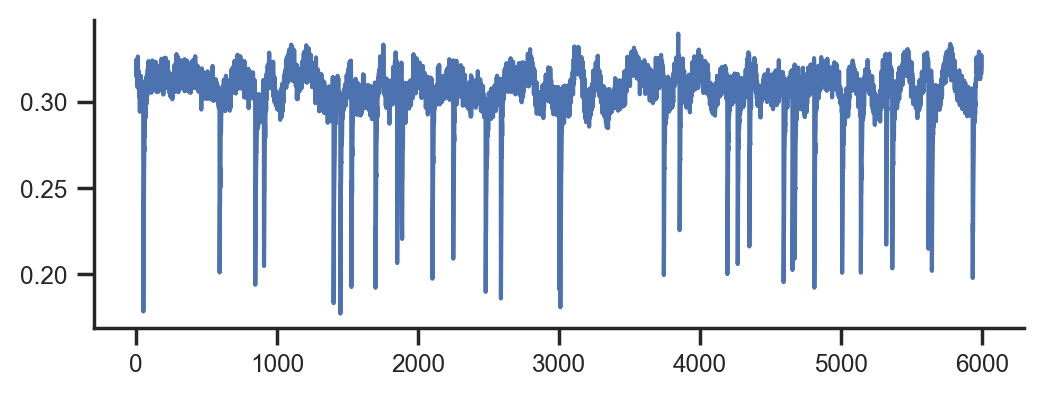

tensor([1.0001, 1.0734], requires_grad=True)

In [27]:
f, ax = plt.subplots(1, 1, figsize=(6, 2))
ax.plot(H[1, :])
f, ax = plt.subplots(1, 1, figsize=(6, 2))
ax.plot(H_[1, :].detach().numpy())
plt.show()

display(h_coef)